In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.layers import Input, Dense, Dropout, Flatten, Embedding, merge
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import Model
np.random.seed(123)

Using Theano backend.


In [2]:
from subprocess import check_output
print(check_output(["ls", "./MarchMadness"]).decode("utf8"))

Icon
RegularSeasonCompactResults.csv
RegularSeasonDetailedResults.csv
Seasons.csv
Teams.csv
TourneyCompactResults.csv
TourneyDetailedResults.csv
TourneySeeds.csv
TourneySlots.csv
sample_submission.csv



In [3]:
data_dir = './MarchMadness/'
df_seeds = pd.read_csv(data_dir + 'TourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'TourneyCompactResults.csv')

In [4]:
df_tour.drop(labels=['Daynum', 'Wscore', 'Lscore', 'Wloc', 'Numot'], inplace=True, axis=1)

In [5]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [6]:
df_winseeds = df_seeds.rename(columns={'Team':'Wteam', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'Team':'Lteam', 'n_seed':'loss_seed'})

In [7]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'Wteam'])

In [8]:
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'Lteam'])

In [9]:
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

In [10]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))

In [11]:
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)

In [12]:
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5537, with best C: 0.01


In [13]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

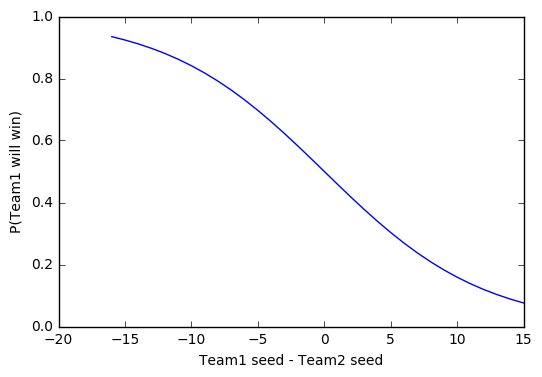

In [14]:
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

In [15]:
df_sample_sub = pd.read_csv(data_dir + 'sample_submission.csv')
n_test_games = len(df_sample_sub)

In [16]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

In [17]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.id)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.Team == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.Team == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed

In [18]:
preds = clf.predict_proba(X_test)[:,1]

In [19]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.pred = clipped_preds

In [20]:
df_sample_sub.to_csv('./MarchMadness/logreg_on_seed.csv', index=False)

In [21]:
dr = pd.read_csv("./MarchMadness/RegularSeasonDetailedResults.csv")

In [22]:
simple_df_1 = pd.DataFrame()
simple_df_1[["team1", "team2"]] =dr[["Wteam", "Lteam"]].copy()
simple_df_1["pred"] = 1

simple_df_2 = pd.DataFrame()
simple_df_2[["team1", "team2"]] =dr[["Lteam", "Wteam"]]
simple_df_2["pred"] = 0

simple_df = pd.concat((simple_df_1, simple_df_2), axis=0)

In [23]:
trans_dict = {t: i for i, t in enumerate(simple_df.team1.unique())}
simple_df["team1"] = simple_df["team1"].apply(lambda x: trans_dict[x])
simple_df["team2"] = simple_df["team2"].apply(lambda x: trans_dict[x])

In [24]:
train = simple_df.values
np.random.shuffle(train)

In [25]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype="int64", name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [26]:
n_factors = 50
n = simple_df.team1.nunique()

team1_in, t1 = embedding_input("team1_in", n, n_factors, 1e-4)
team2_in, t2 = embedding_input("team2_in", n, n_factors, 1e-4)

b1 = create_bias(team1_in, n)
b2 = create_bias(team2_in, n)
print(n)
print(b1)
print(b2)

355
Reshape{2}.0
Reshape{2}.0


In [27]:
x = merge([t1, t2], mode="dot")
x = Flatten()(x)
x = merge([x, b2], mode="sum")
x = merge([x, b1], mode="sum")
x = Dense(1, activation="sigmoid")(x)
model = Model([team1_in, team2_in], x)
model.compile(Adam(0.001), loss="binary_crossentropy")

In [28]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
team1_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
team2_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         17750       team1_in[0][0]                   
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         17750       team2_in[0][0]                   
___________________________________________________________________________________________

In [29]:
history = model.fit([train[:, 0], train[:, 1]], train[:, 2], batch_size=64, nb_epoch=10, verbose=2)

Epoch 1/10
2s - loss: 0.6513
Epoch 2/10
2s - loss: 0.6044
Epoch 3/10
2s - loss: 0.5927
Epoch 4/10
2s - loss: 0.5889
Epoch 5/10
2s - loss: 0.5880
Epoch 6/10
2s - loss: 0.5874
Epoch 7/10
2s - loss: 0.5871
Epoch 8/10
2s - loss: 0.5866
Epoch 9/10
2s - loss: 0.5865
Epoch 10/10
2s - loss: 0.5862


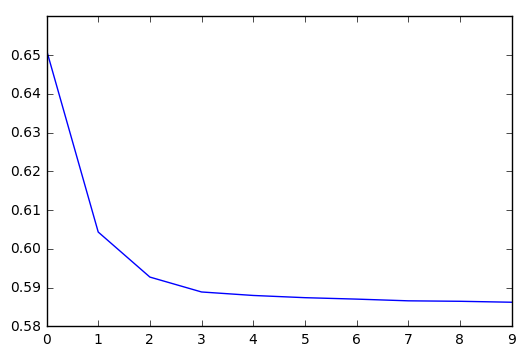

In [30]:
plt.plot(history.history["loss"])
plt.show()

In [31]:
sub = pd.read_csv("./MarchMadness/sample_submission.csv")
sub["team1"] = sub["id"].apply(lambda x: trans_dict[int(x.split("_")[1])])
sub["team2"] = sub["id"].apply(lambda x: trans_dict[int(x.split("_")[2])])
sub.head()

,id,pred,team1,team2
0,2013_1103_1107,0.5,230,294
1,2013_1103_1112,0.5,230,97
2,2013_1103_1125,0.5,230,13
3,2013_1103_1129,0.5,230,190
4,2013_1103_1137,0.5,230,192


In [32]:
sub["pred"] = model.predict([sub.team1, sub.team2])
sub = sub[["id", "pred"]]
sub.head()

,id,pred
0,2013_1103_1107,0.709308
1,2013_1103_1112,0.182212
2,2013_1103_1125,0.577379
3,2013_1103_1129,0.542656
4,2013_1103_1137,0.710934


In [33]:
sub.to_csv("./MarchMadness/CF.csv", index=False)